<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/cyclicLR_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from random import random
from tqdm.notebook import tqdm

## Cyclical lr from scratch

In [2]:
def cyclical_lr_torch(epoch, step_size, base_lr, max_lr):
  cycle = torch.floor(torch.tensor([1]) + (epoch / (2*step_size)))
  x = torch.abs((epoch/step_size) - 2*cycle + 1)

  return (base_lr + (max_lr-base_lr) * torch.max(torch.tensor([0.0]), (1-x)))


In [3]:
def cyclical_lr_np(epoch, step_size, base_lr, max_lr):
  cycle = np.floor(1 + (epoch / (2*step_size)))
  x = np.abs((epoch/step_size) - 2*cycle + 1)

  return (base_lr + (max_lr-base_lr) * (np.max((0, (1-x)))))

## Train a PyTorch model using above function

In [6]:
from torch import nn
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [11]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(3),
                                transforms.ToTensor()                                
])

valset = trainset = datasets.MNIST('./data', train=False, download=True)

In [12]:
class LoadData(Dataset):
  def __init__(self, data, target, transform):
    super().__init__()
    self.data = data
    self.target = target
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.transform(self.data[idx]), self.target[idx])


In [41]:
bs = 32
trainloader = DataLoader(LoadData(valset.data[:8000], valset.targets[:8000], transform), bs, shuffle=True)
valloader = DataLoader(LoadData(valset.data[8000:], valset.targets[8000:], transform), bs)

In [15]:
for data, label in trainloader:
  print(data.shape, label.shape)
  break

for data, label in valloader:
  print(data.shape, label.shape)
  break

torch.Size([32, 3, 28, 28]) torch.Size([32])
torch.Size([32, 3, 28, 28]) torch.Size([32])


In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False)

# uncoment the below code to download pretrained model & freeze the layers

# model = models.resnet18(pretrained=True)
# for params in model.parameters():
#   params.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [122]:
model = model.to(device)

In [123]:
def validate(dataloader):
  correct = 0.0
  for inp, output in dataloader:
    out = model(inp.to(device))

    loss = criterion(out, output.to(device))

    out = torch.argmax(out.data, 1)

    correct += (out==output.to(device)).sum()

  return loss.item(), (correct.item()/(bs*len(valloader)))

Training using cyclical lr

In [124]:
epochs = 8
acc = []
lr = []
iter_counter = -1

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for data, labels in tqdm(trainloader, total=len(trainloader), leave=False):
    iter_counter += 1
    opt.param_groups[0]['lr'] = cyclical_lr_np(iter_counter, 2*len(trainloader), 1e-3, 1e-2)

    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    lr.append(opt.param_groups[0]['lr'])

  model.eval()
  valid = validate(valloader)
  acc.append(valid[1])

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {valid[0]}\tacc: {valid[1]}\n") 

Epoch: 1/8	train_loss: 0.18404600024223328	val_loss: 0.8393237590789795	acc: 0.7981150793650794



Epoch: 2/8	train_loss: 0.38224533200263977	val_loss: 0.028763150796294212	acc: 0.9280753968253969



Epoch: 3/8	train_loss: 0.390600323677063	val_loss: 0.0006226145778782666	acc: 0.9717261904761905



Epoch: 4/8	train_loss: 0.051497917622327805	val_loss: 0.0002656508586369455	acc: 0.9816468253968254



Epoch: 5/8	train_loss: 0.0031536079477518797	val_loss: 0.003545857733115554	acc: 0.9697420634920635



Epoch: 6/8	train_loss: 0.048056334257125854	val_loss: 0.11266009509563446	acc: 0.9429563492063492



Epoch: 7/8	train_loss: 0.0971345379948616	val_loss: 0.00012197695468785241	acc: 0.9771825396825397



Epoch: 8/8	train_loss: 0.0006578373722732067	val_loss: 4.99032175866887e-05	acc: 0.9826388888888888



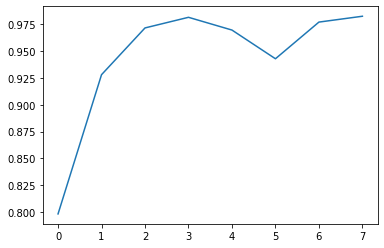

In [125]:
plt.plot(acc)

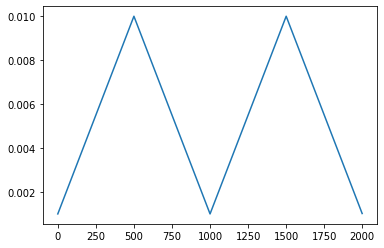

In [126]:
plt.plot(lr)

Training with out cyclical lr

In [127]:
model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-2)

In [128]:
model = model.to(device)

In [129]:
epochs = 8
acc = []

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for j, (data, labels) in tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    losses.append(loss.item())

  model.eval()
  valid = validate(valloader)
  acc.append(valid[1])

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {valid[0]}\tacc: {valid[1]}\n") 

Epoch: 1/8	train_loss: 0.277535617351532	val_loss: 0.12403284013271332	acc: 0.8948412698412699



Epoch: 2/8	train_loss: 0.12656724452972412	val_loss: 0.00707029365003109	acc: 0.9553571428571429



Epoch: 3/8	train_loss: 0.07491379231214523	val_loss: 0.0033603287301957607	acc: 0.9563492063492064



Epoch: 4/8	train_loss: 0.14744426310062408	val_loss: 0.03699132055044174	acc: 0.9469246031746031



Epoch: 5/8	train_loss: 0.02045777253806591	val_loss: 0.003164818976074457	acc: 0.9771825396825397



Epoch: 6/8	train_loss: 0.05808814615011215	val_loss: 0.0419287383556366	acc: 0.9613095238095238



Epoch: 7/8	train_loss: 0.011456728912889957	val_loss: 0.0018843184225261211	acc: 0.9722222222222222



Epoch: 8/8	train_loss: 0.18727606534957886	val_loss: 0.0014664767077192664	acc: 0.9627976190476191



## Fast ai

In [ ]:
!pip install fastai --upgrade

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()[1]

Path('/root/.fastai/data/mnist_png/training')

In [ ]:
def splitter(x): return str(x.parent.parent.name) == 'testing'

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label
)

In [ ]:
ds = db.datasets(path.ls()[0])

In [ ]:
ds.train, ds.valid

In [ ]:
dls = db.dataloaders(path.ls()[0], bs=32)

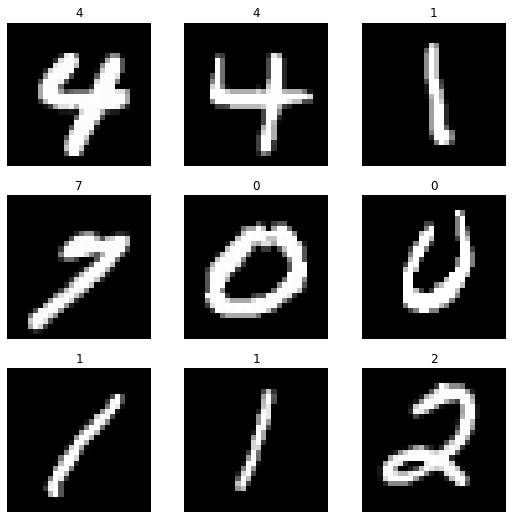

In [ ]:
dls.show_batch()

In [ ]:
db.summary(path)

In [ ]:
learn = Learner(dls, resnet18(pretrained=False), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0010000000474974513)

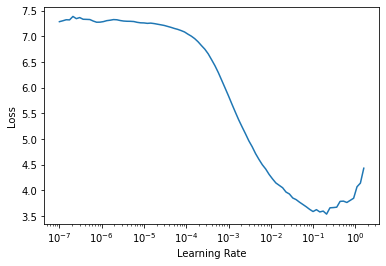

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(8, base_lr=3e-3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.350900,0.586152,0.840500,00:33
1,0.188595,0.284602,0.913000,00:33
2,0.213820,0.122601,0.962500,00:33
3,0.102351,0.079087,0.977000,00:33
4,0.072047,0.083941,0.976500,00:33
5,0.026256,0.040823,0.985500,00:33
6,0.013390,0.030870,0.989000,00:33
7,0.004982,0.028754,0.990000,00:33
